#!pip3 install pandas
#!pip3 install matplotlib
#!pip3 install Pillow
#!pip3 install pyts
#!pip3 install tifffile

In [11]:
im = Image.open(str('../images/training/eating_sheep_5_segment_1.png'))
im.is_animated()


TypeError: 'bool' object is not callable

In [7]:
# Forays into deep learning: Transfer Learning and fast.ai. 

# BLOG POST https://towardsdatascience.com/foray-into-deep-learning-transfer-learning-and-fast-ai-ca0c44c03874
# REPO https://github.com/chr0nikler/HumanActivityRecognition
# PAPER http://kilyos.ee.bilkent.edu.tr/~billur/publ_list/cj14.pdf
# DATASET https://archive.ics.uci.edu/ml/datasets/Daily+and+Sports+Activities

# Data set characteristics: Multivariate time-series
# Attribute characteristics: Real
# Associated Tasks: Classification, Clustering
# Number of instances: 9120
# Number of attributes: 5625





m' notes: 
They use 25Hz sampling frequency. 
They record 19 different activities, performed by 8 subjects
Each activity is performed for 5 minutes, once per subject. 
The 5-min signals (8 * 19 total signals) are divided into 5-sec segments (so we have 60 segments per 5 min signal) so that 480 (=60x8) signal segments are obtained for each activity. 


m' END

Data Set Information:

Brief Description of the Dataset:
---------------------------------
Each of the 19 activities is performed by eight subjects (4 female, 4 male, between the ages 20 and 30) for 5 minutes.
Total signal duration is 5 minutes for each activity of each subject. 
The subjects are asked to perform the activities in their own style and were not restricted on how the activities should be performed.
For this reason, there are inter-subject variations in the speeds and amplitudes of some activities. #### we probably have something like this with our sheep
The activities are performed at the Bilkent University Sports Hall, in the Electrical and Electronics Engineering Building,
and in a flat outdoor area on campus.
Sensor units are calibrated to acquire data at 25 Hz sampling frequency. 
The 5-min signals are divided into 5-sec segments so that 480(=60x8) signal segments are obtained for each activity.

The 19 activities are:
sitting (A1),
standing (A2),
lying on back and on right side (A3 and A4),
ascending and descending stairs (A5 and A6),
standing in an elevator still (A7)
and moving around in an elevator (A8),
walking in a parking lot (A9),
walking on a treadmill with a speed of 4 km/h (in flat and 15 deg inclined positions) (A1
0 and A11),
running on a treadmill with a speed of 8 km/h (A12),
exercising on a stepper (A13),
exercising on a cross trainer (A14),
cycling on an exercise bike in horizontal and vertical positions (A15 and A16),
rowing (A17),
jumping (A18),
and playing basketball (A19).

File structure:

19 activities (a) (in the order given above)
8 subjects (p)
60 segments (s)
5 units on torso (T), right arm (RA), left arm (LA), right leg (RL), left leg (LL)
9 sensors on each unit (x,y,z accelerometers, x,y,z gyroscopes, x,y,z magnetometers)

Folders a01, a02, ..., a19 contain data recorded from the 19 activities.

For each activity, the subfolders p1, p2, ..., p8 contain data from each of the 8 subjects.

In each subfolder, there are 60 text files s01, s02, ..., s60, one for each segment.

In each text file, there are 5 units x 9 sensors = 45 columns and 5 sec x 25 Hz = 125 rows.
Each column contains the 125 samples of data acquired from one of the sensors of one of the units over a period of 5 sec.
Each row contains data acquired from all of the 45 sensor axes at a particular sampling instant separated by commas.

Columns 1-45 correspond to:
T_xacc, T_yacc, T_zacc, T_xgyro, ..., T_ymag, T_zmag,
RA_xacc, RA_yacc, RA_zacc, RA_xgyro, ..., RA_ymag, RA_zmag,
LA_xacc, LA_yacc, LA_zacc, LA_xgyro, ..., LA_ymag, LA_zmag,
RL_xacc, RL_yacc, RL_zacc, RL_xgyro, ..., RL_ymag, RL_zmag,
LL_xacc, LL_yacc, LL_zacc, LL_xgyro, ..., LL_ymag, LL_zmag.

Therefore,
columns 1-9 correspond to the sensors in unit 1 (T),
columns 10-18 correspond to the sensors in unit 2 (RA),
columns 19-27 correspond to the sensors in unit 3 (LA),
columns 28-36 correspond to the sensors in unit 4 (RL),
columns 37-45 correspond to the sensors in unit 5 (LL). 

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import numpy as np

First thing first is to inspect the data, see what it looks like. I don't care about where the data is right now, just want to see it. We will worry about the data layout and creating images from that stuff later.

In [4]:
data_path = './data/a10/p4/s53.txt'
feature_labels = [
    'T_xacc', 'T_yacc', 'T_zacc', 'T_xgyro', 'T_ygyro', 'T_zgyro', 'T_xmag', 'T_ymag', 'T_zmag',
    'RA_xacc', 'RA_yacc', 'RA_zacc', 'RA_xgyro', 'RA_ygyro', 'RA_zgyro', 'RA_xmag', 'RA_ymag', 'RA_zmag',
    'LA_xacc', 'LA_yacc', 'LA_zacc', 'LA_xgyro', 'LA_ygyro', 'LA_zgyro', 'LA_xmag', 'LA_ymag', 'LA_zmag',
    'RL_xacc', 'RL_yacc', 'RL_zacc', 'RL_xgyro', 'RL_ygyro', 'RL_zgyro', 'RL_xmag', 'RL_ymag', 'RL_zmag',
    'LL_xacc', 'LL_yacc', 'LL_zacc', 'LL_xgyro', 'LL_ygyro', 'LL_zgyro', 'LL_xmag', 'LL_ymag', 'LL_zmag'
]
predicted_labels_map = {
    'a01': 'sitting',
    'a02': 'standing',
    'a03': 'lying on back',
    'a04': 'lying on right side',
    'a05': 'ascending stairs',
    'a06': 'descending stairs',
    'a07': 'standing in an elevator',
    'a08': 'moving in elevator',
    'a09': 'walking in lot',
    'a10': 'walking on flat treadmill',
    'a11': 'walking on inclined treadmill',
    'a12': 'running on flat treadmill',
    'a13': 'exercising on stepper',
    'a14': 'exercising on cross-trainer',
    'a15': 'cycling horizontally',
    'a16': 'cycling vertically',
    'a17': 'rowing',
    'a18': 'jumping',
    'a19': 'playing basketball'
}


In [5]:
s01 = pd.read_csv(data_path, names = feature_labels)

In [6]:
s01
# 125 rows are due to 25Hz sampling frequency times 5 sec segment

,T_xacc,T_yacc,T_zacc,T_xgyro,T_ygyro,T_zgyro,T_xmag,T_ymag,T_zmag,RA_xacc,...,RL_zmag,LL_xacc,LL_yacc,LL_zacc,LL_xgyro,LL_ygyro,LL_zgyro,LL_xmag,LL_ymag,LL_zmag
0,9.8306,2.75170,1.7109,-0.671510,0.026210,-0.187510,-0.61891,0.002693,-0.62272,10.0550,...,0.22910,-11.7640,-2.00720,2.83190,-0.44629,0.592740,1.18000,0.94456,0.83450,-0.190060
1,10.2080,1.03390,2.5681,-0.512970,-0.021221,-0.042970,-0.61834,0.013309,-0.62170,11.8340,...,0.27382,-10.3260,0.29700,-2.23220,0.79196,-0.443270,1.04260,0.97990,0.80042,-0.206910
2,9.5058,0.54377,2.4252,-0.437870,-0.072341,0.154250,-0.62115,0.022804,-0.62120,11.5220,...,0.32720,-9.8205,-0.69214,-4.15350,-0.30317,-0.070990,1.39400,1.02090,0.75843,-0.186900
3,7.5416,1.24140,2.3627,-0.390800,-0.017260,0.246920,-0.62057,0.038348,-0.61994,10.0420,...,0.33948,-10.5490,0.43445,-0.65191,-0.58086,0.393310,1.27510,1.05020,0.71247,-0.138890
4,6.7527,1.44050,2.3057,-0.390630,-0.012452,0.217650,-0.62243,0.052628,-0.61904,8.1316,...,0.33653,-10.0620,-0.24657,1.19960,-0.42043,-0.044613,1.22820,1.07400,0.66303,-0.101720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,8.3484,0.63757,3.5288,-0.249600,-0.103660,0.119020,-0.63825,0.103770,-0.60723,7.1388,...,0.27573,-9.5539,0.17673,-0.91218,0.36135,-0.050679,1.05230,1.11490,0.45759,-0.051466
121,9.1454,0.63053,3.6915,0.007917,0.011988,0.172760,-0.64000,0.113330,-0.60454,7.5087,...,0.24845,-10.5750,-0.92142,-1.65700,-0.94274,-0.158220,0.96572,1.12840,0.41189,-0.039982
122,9.8526,0.56468,3.9202,-0.042648,0.072063,0.198960,-0.63777,0.120990,-0.60532,8.4071,...,0.22961,-10.0640,-4.24650,-2.03830,-0.82231,-0.448130,0.75084,1.13520,0.37648,-0.040429
123,11.2520,2.18880,4.4040,-0.148850,0.088858,0.009271,-0.64042,0.129950,-0.60441,9.5418,...,0.28675,-10.4070,-2.99770,-1.97350,-0.32116,-0.232500,0.37488,1.13890,0.34890,-0.047402


Data frame looks as we expect it to. Some summary statistics to get a feel for the data

In [7]:
s01.describe()



,T_xacc,T_yacc,T_zacc,T_xgyro,T_ygyro,T_zgyro,T_xmag,T_ymag,T_zmag,RA_xacc,...,RL_zmag,LL_xacc,LL_yacc,LL_zacc,LL_xgyro,LL_ygyro,LL_zgyro,LL_xmag,LL_ymag,LL_zmag
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,...,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,9.292610,0.289298,3.058085,-0.027966,0.004146,0.011116,-0.627030,0.053694,-0.623534,9.406722,...,0.294411,-10.134217,-1.248346,-1.137674,-0.092528,0.087657,0.110157,0.994895,0.692867,-0.122410
std,2.008647,1.147761,0.918290,0.467237,0.125124,0.221276,0.008042,0.051850,0.008886,1.955647,...,0.032937,2.614359,6.610308,3.981051,1.217035,0.420766,1.260819,0.125401,0.201661,0.078458
min,6.482400,-2.535200,0.684220,-0.863930,-0.235550,-0.488370,-0.642680,-0.017086,-0.646970,6.370300,...,0.213190,-17.723000,-28.248000,-26.343000,-2.456000,-0.536910,-2.604800,0.786370,0.332400,-0.337330
25%,7.878600,-0.506590,2.474600,-0.415660,-0.075125,-0.171300,-0.633740,0.001076,-0.628930,8.011000,...,0.277040,-11.386000,-3.178200,-2.236100,-0.942740,-0.244050,-1.020200,0.869560,0.496610,-0.180970
50%,9.100000,0.457960,2.933400,-0.123550,-0.017260,0.021223,-0.627130,0.050553,-0.622940,9.081100,...,0.300630,-10.062000,-0.333150,-1.257500,-0.254090,-0.057939,0.683760,1.019200,0.732970,-0.099199
75%,10.241000,1.067500,3.787600,0.338740,0.063363,0.174090,-0.620760,0.104080,-0.617980,10.687000,...,0.315850,-8.754500,2.210800,0.349170,0.738270,0.442930,1.130900,1.117800,0.877700,-0.057985
max,15.278000,2.927600,5.138700,0.990200,0.424150,0.505170,-0.607990,0.139630,-0.604410,15.625000,...,0.350100,-4.967100,17.361000,16.749000,2.849700,0.879950,2.189900,1.165500,0.952180,0.002905


Expectations are that accelerations have larger numbers in general, but everything else is pretty small. The dataset will require normalization for proper image conversion. Lets graph some of the acceleration data, just for the T. 

125
range(0, 125)


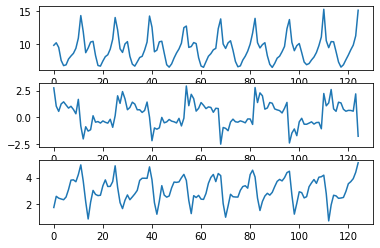

In [8]:
# where's this 'time' object being used???
# len is an nrow
time = range(len(s01))
print(len(s01))
print(time)



plt.subplot(3,1,1)
plt.plot(s01['T_xacc'])
plt.subplot(3,1,2)
plt.plot(s01['T_yacc'])
plt.subplot(3,1,3)
plt.plot(s01['T_zacc'])

Note the y axis is different, so on one graph this would look different, but the standard deviation is not too different, so the shapes look mostly the same (more action in the x and z axes than the y axis)

For now, let's branch off into just grabbing the acceleration stats. That's all I'm interested in right now. Later, if we want to use all the features, it should be trivial to account for the rest and produce image representations based on that, as long as our mapping is consistent

I use the simple strategy described in [this paper](https://www.researchgate.net/publication/259899616_Images_in_mind_-_Design_metaphor_and_method_to_classify_driver_distraction_in_critical_situations) to generate images from these variables. 
Steps necessary are

1. Normalize each feature BY SENSOR. If we normalize T_xacc separate from T_yacc, we lose the information that for some activity, there was a lot of acceleration in the x, but no y_acc (m' this is done by having the np.max determined across all columns, same with np.min, that is, the np.max is the max value of the whole data-frame containing the acc data, not the max of each column (acc axis)). This occurs per sensor type because gyroscopes, accelerometers, and magnetometers operate in different units. This also needs to be done by aggregating the data across all segments, not just per segment, because then information loss occurs between different activities. 
2. Convert range of [0,1] to [0,255] for grayscale
3. Save images 

What follows is a quick test of the above flow before tackling it across the data

In [11]:
# s01 is an object created by doing a read_csv on 'data_path = './data/a10/p4/s53.txt''.
# so all this is being done on only 1 segment of 1 person of 1 activity?????

# 'step' objects created by me to understand the code 

# step 1 keeps columns that have 'acc' inside their name. 'axis=1' means to apply the filter to columns. We are left with 15 columns and 125 rows
# step1 = s01.filter(regex='acc$', axis=1)
# print(step1)

# step2 removes column names and just gives you the values
# step2 = step1.values
# print(step2)


# This step flattens row-wise (because of default arg-value of the function)
# step3 = step2.flatten()
# print(step3)

acceleration_data = s01.filter(regex='acc$', axis=1).values.flatten()


#print(acceleration_data)
#print(acceleration_data.shape) # this results in a vector of length 1875, which equals 15 * 125
#print(len(acceleration_data)) # same as with .shape









# in python a lambda function is an anonymous function. 
# ptp comes from "peak to peak". Gives range of values (maximum - minimum) along an axis. 
# pd.apply defaults to columns. wtf '1 or columns: applies to rows'
# this 'normalized' object does 2 things: normalization to 0-1 and then scaling to 0-255
normalized = s01.filter(regex='acc$', axis=1).apply(lambda x: 255 * (x - acceleration_data.min())/np.ptp(acceleration_data))


[  9.8306   2.7517   1.7109 ... -11.035  -10.683   -3.4465]
57.231
28.983
-28.248
57.231


In [51]:
normalized.describe()

,T_xacc,T_yacc,T_zacc,RA_xacc,RA_yacc,RA_zacc,LA_xacc,LA_yacc,LA_zacc,RL_xacc,RL_yacc,RL_zacc,LL_xacc,LL_yacc,LL_zacc
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,167.266961,127.151560,139.488244,167.775402,143.509120,123.889744,167.312779,110.940102,141.749905,80.546602,126.179974,120.317706,80.708265,120.300392,120.793507
std,8.949783,5.113995,4.091558,8.713635,7.013109,5.344991,8.638649,4.083693,6.758035,20.539111,33.879679,10.522895,11.648609,29.453066,17.738078
min,154.745715,114.566651,128.911186,154.246239,126.656060,114.356345,157.198983,103.024794,131.765817,1.768884,20.282015,89.856634,46.895476,0.000000,8.487970
25%,160.966661,123.605381,136.888452,161.556586,137.796509,118.587854,160.697096,108.111784,135.060754,66.812130,106.567018,116.570346,75.130786,111.701683,115.899329
50%,166.408764,127.903056,138.932694,166.324553,144.942889,123.990525,164.171594,111.072994,142.761860,82.082455,123.182096,119.094905,81.030036,124.378165,120.259606
75%,171.492635,130.618939,142.738691,173.479845,148.539917,128.497169,171.256487,114.037768,146.473397,89.338890,140.435577,122.400490,86.855769,135.713058,127.418328
max,193.935629,138.906851,148.758688,195.481732,157.528254,133.617576,195.802537,120.915029,155.811501,131.956964,255.000000,181.433139,103.731011,203.216701,200.489857


[[169 171 168 ... 169 175 193]
 [138 130 128 ... 128 135 117]
 [133 137 136 ... 143 145 148]
 ...
 [ 73  79  82 ...  81  79  76]
 [116 127 122 ... 106 112  78]
 [138 115 107 ... 116 117 110]]
<PIL.Image.Image image mode=L size=125x15 at 0x7FED4C688B50>


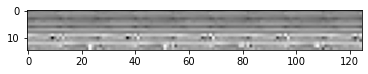

In [12]:

img_array = normalized.to_numpy().astype(np.uint8).T
print(img_array)


im = Image.fromarray(img_array)
print(im)

plt.imshow(img_array, cmap='Greys')


im.save('a01p1s01.png')

The below, until the end, does the actual data reading, normalization, and image saving

In [16]:
stats = {'acc': {}, 'gyro': {}, 'mag': {}}


AttributeError: 'dict' object has no attribute 'dtype'

In [54]:
def update_stats(df):
    acc_data = df.filter(regex='acc$', axis=1).values.flatten()
    stats['acc']['min'] = acc_data.min()
    stats['acc']['max'] = acc_data.max()
    gyro_data = df.filter(regex='gyro$', axis=1).values.flatten()
    stats['gyro']['min'] = gyro_data.min()
    stats['gyro']['max'] = gyro_data.max()
    mag_data = df.filter(regex='mag$', axis=1).values.flatten()
    stats['mag']['min'] = mag_data.min()
    stats['mag']['max'] = mag_data.max()


def get_normalization_stats(path):
    for dirName, subDirs, fileList in os.walk(path):
        if('s01.txt' in fileList):
            for file in fileList:
                df = read_data(os.path.join(dirName,file))
                update_stats(df)
    stats['acc']['ptp'] = stats['acc']['max'] - stats['acc']['min']
    stats['gyro']['ptp'] = stats['gyro']['max'] - stats['gyro']['min']
    stats['mag']['ptp'] = stats['gyro']['max'] - stats['gyro']['min']
            
def create_images(data_path, save_path):
    for dirName, subDirs, fileList in os.walk(data_path):
        if('s01.txt' in fileList):
            for file in fileList:
                df = create_normalized_df(os.path.join(dirName,file))
                # Only care about acc right now.
                df = df.filter(regex='acc$', axis=1)
                save_image(df, os.path.join(dirName,file), save_path)
                
            
def save_image(df, original_path, save_path):
    image_name = create_image_name(original_path)
    img_array = df.to_numpy().astype(np.uint8).T
    im = Image.fromarray(img_array)
    im.save(os.path.join(save_path,image_name))
    
def create_image_name(original_path):
    unlabeled_data = original_path.split('/')[2:]
    unlabeled_data[0] = predicted_labels_map[unlabeled_data[0]].replace(' ', '_')
    return'_'.join(unlabeled_data).replace('.txt', '.png')
            
def read_data(path):
    return pd.read_csv(path, names=feature_labels)
      
def create_normalized_df(path):
        ## TODO reject column_regex if it is not one of
        # acc$, gyro$, mag$, reject
        df = read_data(path)
        #column_key = regex[:len(regex)-1]
        acc_df = df.filter(regex='acc$', axis=1).apply(lambda x: round(255 * (x - stats['acc']['min'])/stats['acc']['ptp']))
        gyro_df = df.filter(regex='gyro$', axis=1).apply(lambda x: round(255 * (x - stats['gyro']['min'])/stats['gyro']['ptp']))
        mag_df = df.filter(regex='mag$', axis=1).apply(lambda x: round(255 * (x - stats['mag']['min'])/stats['mag']['ptp']))
        
        return acc_df.join(gyro_df).join(mag_df)
          

In [55]:
data_path = './data'
save_path = './images'
get_normalization_stats(data_path)

stats

{'acc': {'min': -20.463, 'max': 17.864, 'ptp': 38.327},
 'gyro': {'min': -3.5895, 'max': 3.5001, 'ptp': 7.089600000000001},
 'mag': {'min': -0.57703, 'max': 0.61703, 'ptp': 7.089600000000001}}

We can see that the stats have been populated. With them, we'll normalized each segement of data and create an image for it. 

**Note**: I've read that using ptp can be dangerous if there is a 0 difference array, and that borrowing `minmax_scale` from sklearn might be more appropriate.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [56]:
create_images(data_path, save_path)

In [36]:
# Testing the problem if there's a 0 difference array and we are using np.ptp instead of sklearn.minmax_scale


test = pd.DataFrame(np.array([[1, 1], [1, 1]]))
ptpobject = np.ptp(test)
print(ptpobject) # not sure why I don't get all 0s and get one 1 

# there's no aparent problem in the function itself, the problem may arise when we normalize, because we would be dividing by 0. Maybe sklearn.mimax_scale gives
# default value when the difference is 0?

print(1 / ptpobject)


from sklearn import preprocessing


skobject = preprocessing.minmax_scale(test)
print(skobject) # here I do get all 0's

print(1 / skobject)

0    0
1    0
dtype: int64
0    inf
1    inf
dtype: float64
[[0. 0.]
 [0. 0.]]
[[inf inf]
 [inf inf]]


/home/franfram/anaconda3/envs/aar/lib/python3.10/site-packages/numpy/core/_methods.py:276: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  umr_maximum(a, axis, None, out, keepdims),
/home/franfram/anaconda3/envs/aar/lib/python3.10/site-packages/numpy/core/_methods.py:277: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  umr_minimum(a, axis, None, None, keepdims),
/tmp/ipykernel_9183/1844868659.py:20: RuntimeWarning: divide by zero encountered in true_divide
  print(1 / skobject)
